In [1]:
import sys
sys.path.append('C:/maldb/python/mlp/')

import tensorflow as tf
from tensorflow import keras

import numpy as np
np.set_printoptions(threshold=np.inf)

import matplotlib.pyplot as plt

from ionizer import *

In [2]:
#When we shuffle our training and test arrays, we need to shuffle them in unison so that the indices in the labels array line up with their corresponding peptide in the training array.
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

#To avoid feeding wildly varying numbers into the NN, we normalize things by subtracting the mean from each feature value and dividing by the standard deviation
def normalize_data(data):
    mean = data.mean(axis=0)
    data -= mean

    std = data.std(axis=0)
    data /= std
    
    return data

In [3]:
from keras import models
from keras import layers
from keras import regularizers

#Lets make our dense model
def build_model():

    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(feature_vector_length,)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='rmsprop', 
        loss='binary_crossentropy', 
        metrics=[
            keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5),
            tf.keras.metrics.Precision(), 
            tf.keras.metrics.Recall()
        ]
    )
    
    return model 

In [4]:
#Get the data from the excel sheet, calculate feature vectors for each entry (row) using ionizers.py
train_data, train_seqs, train_labels = get_ionizer_training_data('C:/maldb/python/mlp/data/ionizers.csv')

#Let's vectorize our sequences
x_train = normalize_data(train_data).astype('float32')
y_train = train_labels.astype('float32')
x_train, y_train = unison_shuffled_copies(x_train, y_train)

#Cut features
x_train = x_train[:, :50]

#Make a test set
test_set_size = 50
x_test = x_train[:test_set_size]
y_test = y_train[:test_set_size]

x_train = x_train[test_set_size:]
y_train = y_train[test_set_size:]

#For the input layer
feature_vector_length = x_train.shape[1]

In [5]:
#Define the number of folds... this will give us an 80/20 split
k = 5
epochs = 120
num_val_samples = len(x_train) // k
scores_binacc = []
scores_precision = []
scores_recall = []

#Train the dense model in k iterations
for i in range(k):
    print('Processing fold #', i)
    val_data = x_train[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples : (i + 1) * num_val_samples]
    
    print('Validation partition =  ', i * num_val_samples, (i + 1) * num_val_samples)
    print('Training partition 1 = ', 0, i * num_val_samples)
    print('Training partition 2 = ', (i+1) * num_val_samples, len(x_train))
    
    partial_train_data = np.concatenate(
        [
            x_train[:i * num_val_samples],
            x_train[(i+1) * num_val_samples:]
        ], 
        axis=0
    )
    
    partial_train_targets = np.concatenate(
        [
            y_train[:i * num_val_samples],
            y_train[(i+1) * num_val_samples:]
        ],
        axis=0
    )
    
    model = build_model()
    model.fit(
        partial_train_data, 
        partial_train_targets, 
        epochs=epochs, 
        verbose=0
    )
    
    val_loss, val_binacc, val_precision, val_recall = model.evaluate(val_data, val_targets, verbose=0)
    scores_binacc.append(val_binacc)
    scores_precision.append(val_precision)
    scores_recall.append(val_recall)

Processing fold # 0
Validation partition =   0 123
Training partition 1 =  0 0
Training partition 2 =  123 616
Processing fold # 1
Validation partition =   123 246
Training partition 1 =  0 123
Training partition 2 =  246 616
Processing fold # 2
Validation partition =   246 369
Training partition 1 =  0 246
Training partition 2 =  369 616
Processing fold # 3
Validation partition =   369 492
Training partition 1 =  0 369
Training partition 2 =  492 616
Processing fold # 4
Validation partition =   492 615
Training partition 1 =  0 492
Training partition 2 =  615 616


In [6]:
print('Mean Validation Binary Accuracy: ', np.mean(scores_binacc))
print('Mean Validation Precision: ', np.mean(scores_precision))
print('Mean Validation Recall: ', np.mean(scores_recall))

Mean Validation Binary Accuracy:  0.9341487646102905
Mean Validation Precision:  0.9129393815994262
Mean Validation Recall:  0.8955269813537597


In [7]:
x_test_predictions = model.predict(np.array(x_test))

b = keras.metrics.BinaryAccuracy()
p = keras.metrics.Precision() 
r = keras.metrics.Recall()

print(y_test)

b.update_state(
    [y_test],
    [x_test_predictions]
)
p.update_state(
    [y_test],
    [x_test_predictions]
)
r.update_state(
    [y_test],
    [x_test_predictions]
)

print('Test Binary Accuracy: ', b.result().numpy())
print('Test Precision: ', p.result().numpy())
print('Test Recall: ', r.result().numpy())

[0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0.]
Test Binary Accuracy:  0.84
Test Precision:  0.78571427
Test Recall:  0.6875


dict_keys(['loss', 'binary_accuracy', 'precision_2', 'recall_2', 'val_loss', 'val_binary_accuracy', 'val_precision_2', 'val_recall_2'])


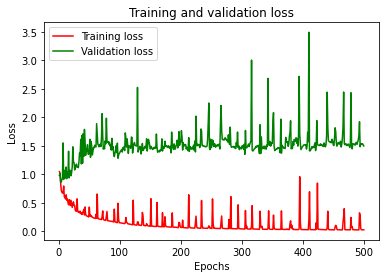

In [22]:
history_dict = history.history
print(history_dict.keys())
e = range(1, epochs + 1)

loss = history_dict['loss']
val_loss = history_dict['val_loss']
plt.plot(e, loss, 'r-', label='Training loss')
plt.plot(e, val_loss, 'g-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
#We should randomly shuffle our data before splitting it into training and test sets
#The peptides were deposited into the array on a per-protein basis, so each protein may have a specific AA composition, properties etc.
#Thus, if the first 85% of our data were soluble proteins, and the last 15% were membrane proteins, we are likely to have poor prediction since our model never saw/had a chance to learn on membrane peptides!

#Shuffle!
x_train, y_train = unison_shuffled_copies(x_train, y_train)

In [24]:
#Slice the training and validation sets
partial_x_train = x_train[:split]
x_val = x_train[split:]

partial_y_train = y_train[:split]
y_val = y_train[split:]

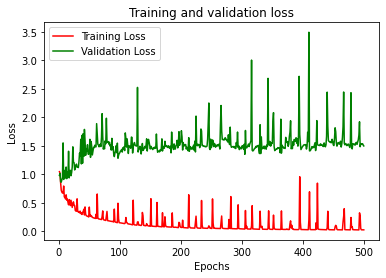

In [25]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
plt.plot(e, loss_values, 'r-', label='Training Loss')
plt.plot(e, val_loss_values, 'g-', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


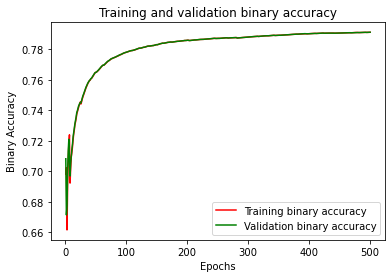

In [26]:
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']
plt.plot(e, acc_values, 'r-', label='Training binary accuracy')
plt.plot(e, val_acc_values, 'g-', label='Validation binary accuracy')
plt.title('Training and validation binary accuracy')
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.legend()
plt.show()

In [10]:
acc_values = history_dict['precision_10']
val_acc_values = history_dict['val_precision_10']
plt.plot(e, acc_values, 'r-', label='Training precision')
plt.plot(e, val_acc_values, 'g-', label='Validation precision')
plt.title('Training and validation binary precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

KeyError: 'precision_10'

(array([397.,  15.,   7.,   2.,   1.,   1.,   0.,   0.,   1.,   2.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   1.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   1.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,   2.,
          3.,   3.,   3.,   6.,  18., 191.]),
 array([3.6779263e-15, 2.0000000e-02, 3.9999999e-02, 5.9999999e-02,
        7.9999998e-02, 1.0000000e-01, 1.2000000e-01, 1.4000000e-01,
        1.6000000e-01, 1.8000001e-01, 2.0000000e-01, 2.2000000e-01,
        2.3999999e-01, 2.5999999e-01, 2.8000000e-01, 3.0000001e-01,
        3.1999999e-01, 3.4000000e-01, 3.6000001e-01, 3.8000000e-01,
        4.0000001e-01, 4.1999999e-01, 4.4000000e-01, 4.6000001e-01,
        4.7999999e-01, 5.0000000e-01, 5.1999998e-01, 5.4000002e-01,
        5.6000000e-01, 5.7999998e-01, 6.0000002e-01, 6.2000000e-01,
        6.3999999e-01, 6.6000003e-01, 6.8000001e-01, 6.9999999e-01,
        7.2000003e-01, 7.4000001e-01, 7.599999

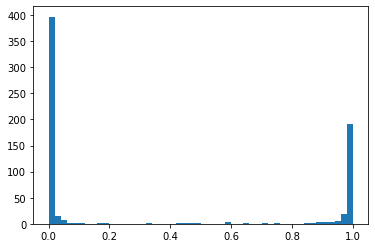

In [112]:
plt.hist(model.predict(x_train), bins=50)

NameError: name 'x_test' is not defined